In [1]:
import operator
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from performance_profile import check_if_minimized
from plotting_utils import (
  METRIC_FMT,
  PLOT_STYLE,
  clean_results,
  read_data_from_logs,
)
from tueplots import bundles, figsizes

# %matplotlib widget

/home/frank/anaconda3/envs/algoperf_pt/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
SELF_TUING = False

log_path = "../../submissions_algorithms_v0.5/logs/algoperf_scoring_v05/"
if SELF_TUING:
  log_path = os.path.join(log_path, "self_tuning")
else:
  log_path = os.path.join(log_path, "external_tuning")

full_results = read_data_from_logs(log_path)
clean_results_df = clean_results(full_results)

Reading data for submission: shampoo_submission
['ogbg_pytorch', 'librispeech_conformer_pytorch', 'fastmri_tanh_pytorch', 'ogbg_model_size_pytorch', 'criteo1tb_pytorch', 'librispeech_conformer_layernorm_pytorch', 'imagenet_vit_pytorch', 'wmt_pytorch', 'librispeech_deepspeech_pytorch', 'imagenet_resnet_pytorch', 'criteo1tb_embed_init_pytorch', 'fastmri_pytorch', 'imagenet_resnet_large_bn_init_pytorch', 'wmt_glu_tanh_pytorch']
['ogbg_pytorch', 'librispeech_conformer_pytorch', 'fastmri_tanh_pytorch', 'ogbg_model_size_pytorch', 'criteo1tb_pytorch', 'librispeech_conformer_layernorm_pytorch', 'imagenet_vit_pytorch', 'wmt_pytorch', 'librispeech_deepspeech_pytorch', 'imagenet_resnet_pytorch', 'criteo1tb_embed_init_pytorch', 'fastmri_pytorch', 'imagenet_resnet_large_bn_init_pytorch', 'wmt_glu_tanh_pytorch']
['ogbg_pytorch', 'librispeech_conformer_pytorch', 'fastmri_tanh_pytorch', 'ogbg_model_size_pytorch', 'criteo1tb_pytorch', 'librispeech_conformer_layernorm_pytorch', 'imagenet_vit_pytorch', '

2024-09-25 14:29:47.750120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/frank/anaconda3/envs/algoperf_pt/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [17]:
def get_best_trial_index(workload_df,
                         validation_metric,
                         validation_target=None):
  """Get the eval index in which a workload reaches the target metric_col.

  Args:
    workload_df: A subset of a submission's trials DataFrame that
      includes only the trials in a single workload.
    metric_col: Name of array column in workload_df (e.g. `validation/l1_loss`).
    target: Target value for metric_col.

  Returns:
    Tuple of trial index and time index where the workload reached the target
      metric_col. Return (-1, -1) if not reached.
  """
  is_minimized = check_if_minimized(validation_metric)
  validation_series = workload_df["performance"]
  validation_series = validation_series[validation_series != np.nan]

  op = operator.le if is_minimized else operator.ge
  validation_target_reached = validation_series.apply(
      lambda x: op(x, validation_target))
  target_reached = pd.Series(validation_target_reached)

  # Remove trials that never reach the target
  target_reached = target_reached[target_reached.apply(np.any)]

  # If no trials reach the target return the trial with the best performance
  if len(target_reached) == 0:
    best_validation_performance = validation_series.apply(np.max)
    trial = best_validation_performance.idxmin(
    ) if is_minimized else best_validation_performance.idxmax()
    return trial, -1
  # Else, return the eval index of the earliest point the target is reached.
  else:
    index_reached = target_reached.apply(np.argmax)
    trial = index_reached.idxmin()
    return trial, index_reached[trial]


def plot_workload_results(df, ax, performance_target, performance_metric):
  # display(df)

  # For each study check trials
  for study, group in df.groupby('study'):
    # Get trial and time index that reaches target
    trial_idx, time_idx = get_best_trial_index(
          group, performance_metric, performance_target)

    # # Iterate through each row of the DataFrame
    # for index, row in df.iterrows():
    #   # Extract the runtime and performance lists
    runtime = group['runtime'].loc[trial_idx]
    performance = group['performance'].loc[trial_idx]

    # Create a line plot for the current row
    study_name = group['study'].loc[trial_idx].replace("_", " ").capitalize()
    trial_name = group['trial'].loc[trial_idx].replace("_", " ").capitalize()
    ax.plot(
        runtime,
        performance,
        label=f"{study_name}, {trial_name}",
        lw=1,
        ls="--" if time_idx == -1 else "-")


def plot_submission(submission, workload, results_df, ax=None, title=None):

  if ax is None:
    fig, ax = plt.subplots()

  # Select the results of the chosen submission
  df = results_df[submission]
  # Select all rows of the chosen workload
  df = df[df["workload"] == workload]

  # Compute relevant information
  runtime_budget = 3 * df["runtime_budget"].unique(
  )[0] if SELF_TUING else df["runtime_budget"].unique()[0]
  performance_target = df["performance_target"].unique()[0]
  performance_metric = df['validation_metric'].unique()[0]
  performance_metric_clean = performance_metric.split("/")[-1]

  plot_workload_results(df, ax, performance_target, performance_metric)

  # Style the plot
  x_lims = [0, runtime_budget]
  y_lims = [0, performance_target]
  ax_lims_push_perc = 0.03
  ax.set_xlabel("Runtime in seconds")
  ax.set_ylabel(METRIC_FMT[performance_metric_clean])
  # ax.set_yscale("log")
  ax_lims_push = [
      ax_lims_push_perc * (x_lims[1] - x_lims[0]),
      ax_lims_push_perc * (y_lims[1] - y_lims[0]),
  ]
  # ax.set_xlim(
  #     left=x_lims[0] - ax_lims_push[0], right=x_lims[1] + ax_lims_push[0])
  # ax.set_ylim(bottom=y_lims[0], top=y_lims[1] + ax_lims_push[1])

  # Vertical line for the runtime budget
  ax.axvline(runtime_budget, color="gray", linestyle="--", linewidth=1)
  # Horizontal line for the performance target
  ax.axhline(performance_target, color="gray", linestyle="--", linewidth=1)
  # ax.text(runtime_budget, performance_target, "target performance", ha="right", va="top")
  if submission.endswith("_self"):
    submission = submission[:-5]
  elif submission.endswith("_ext"):
    submission = submission[:-4]

  if title is not None:
    ax.set_title(f"{PLOT_STYLE[submission]['label']}")

  ax.legend()

  # plt.show()

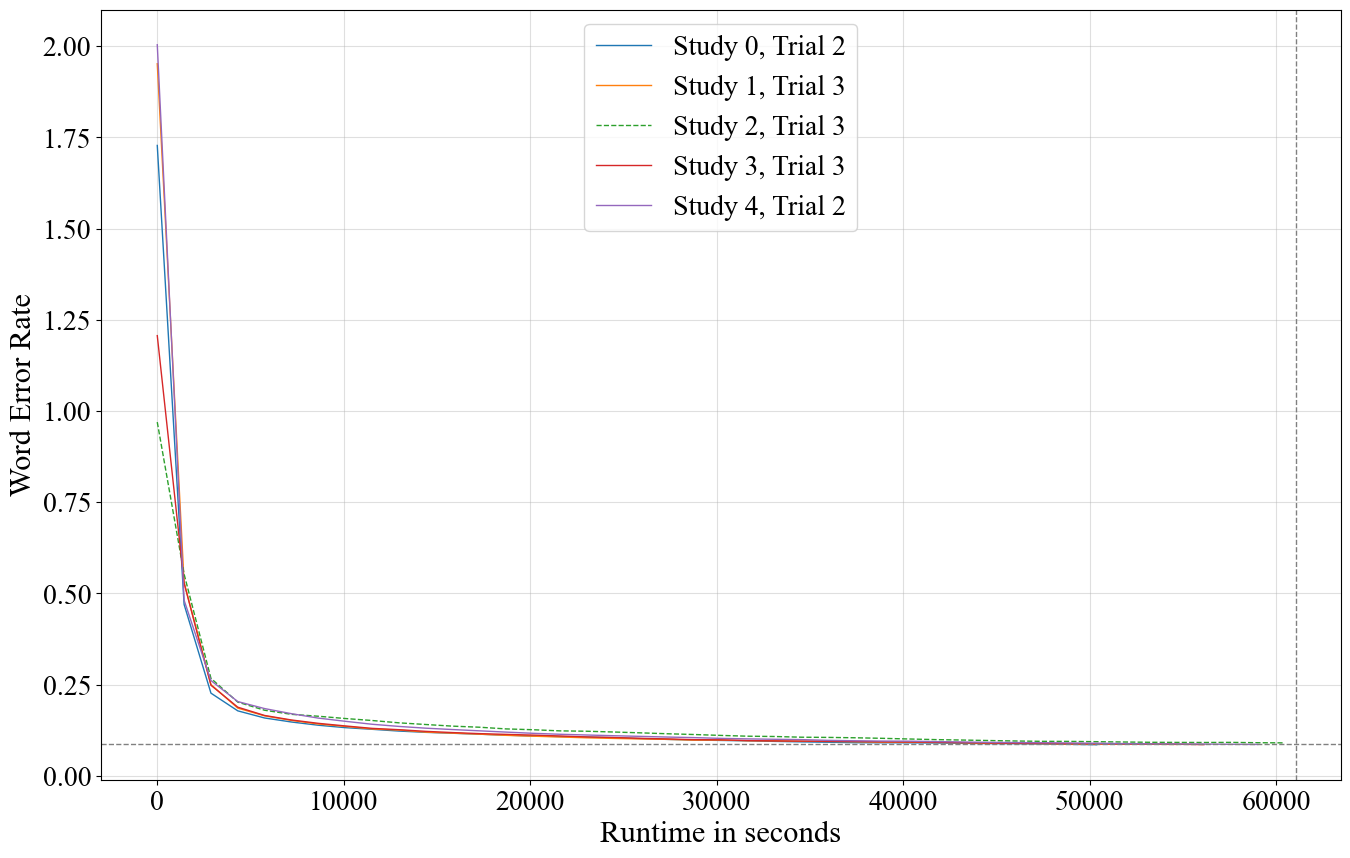

In [18]:
plot_submission("nadamp", "imagenet_resnet", results_df=clean_results_df)

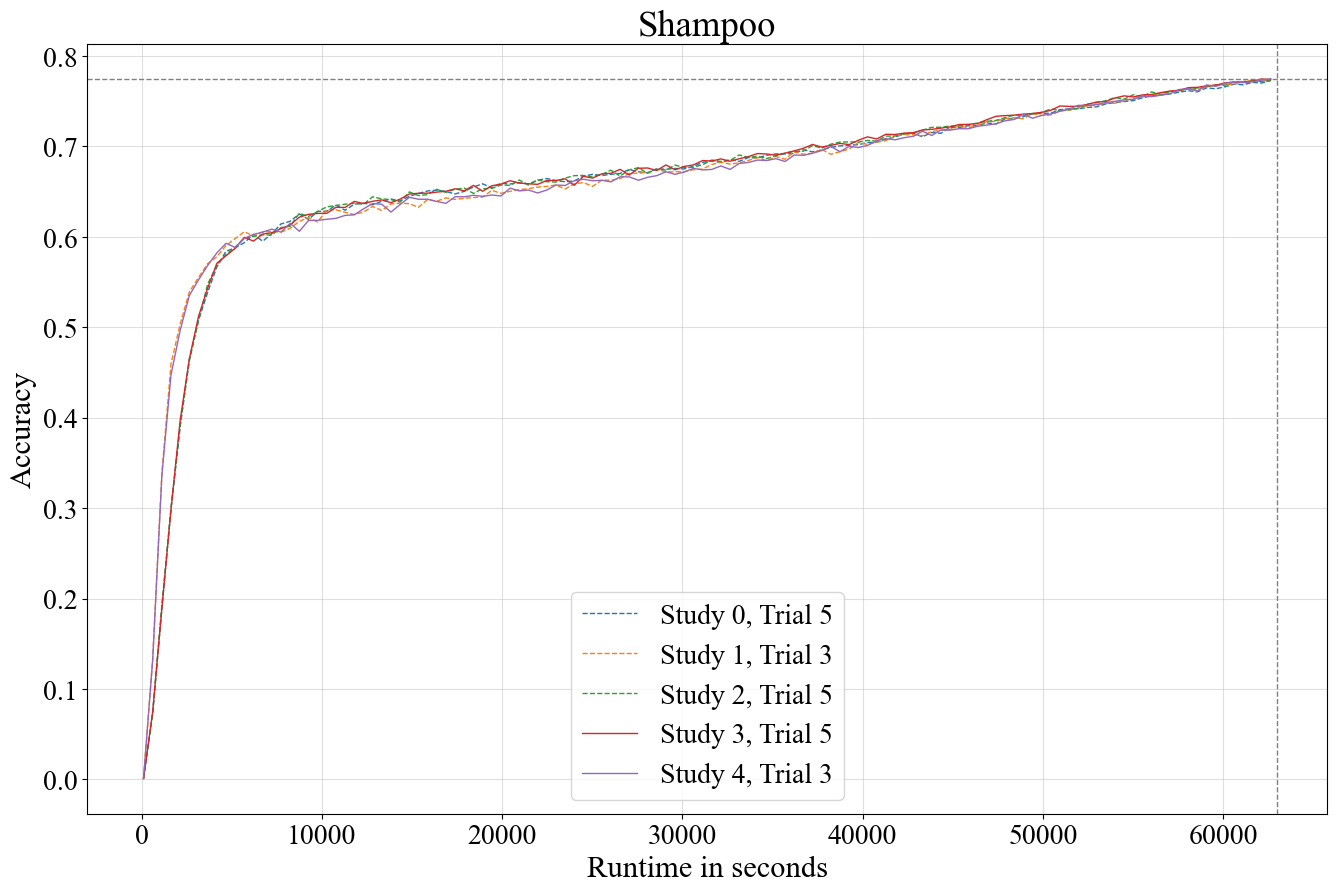

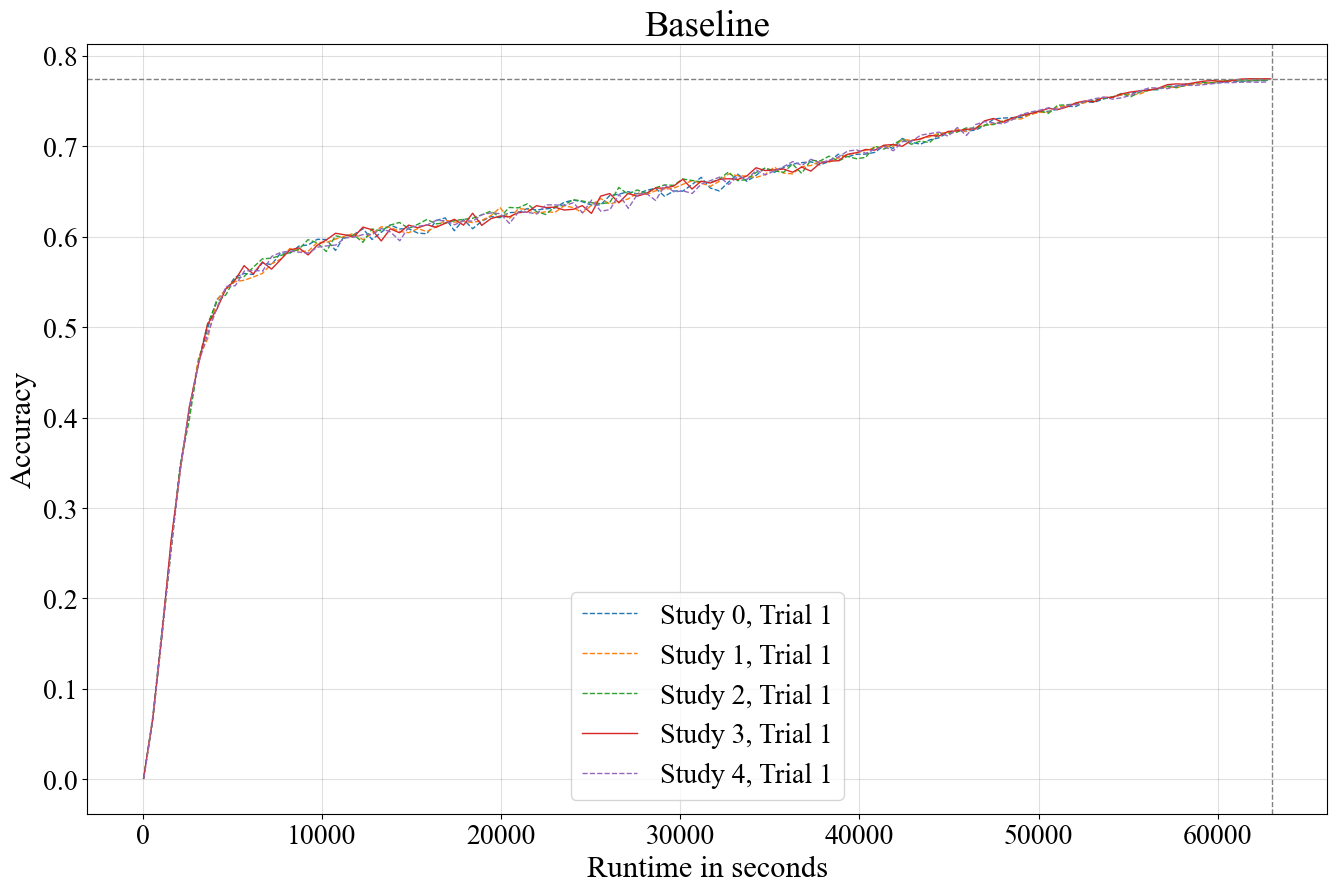

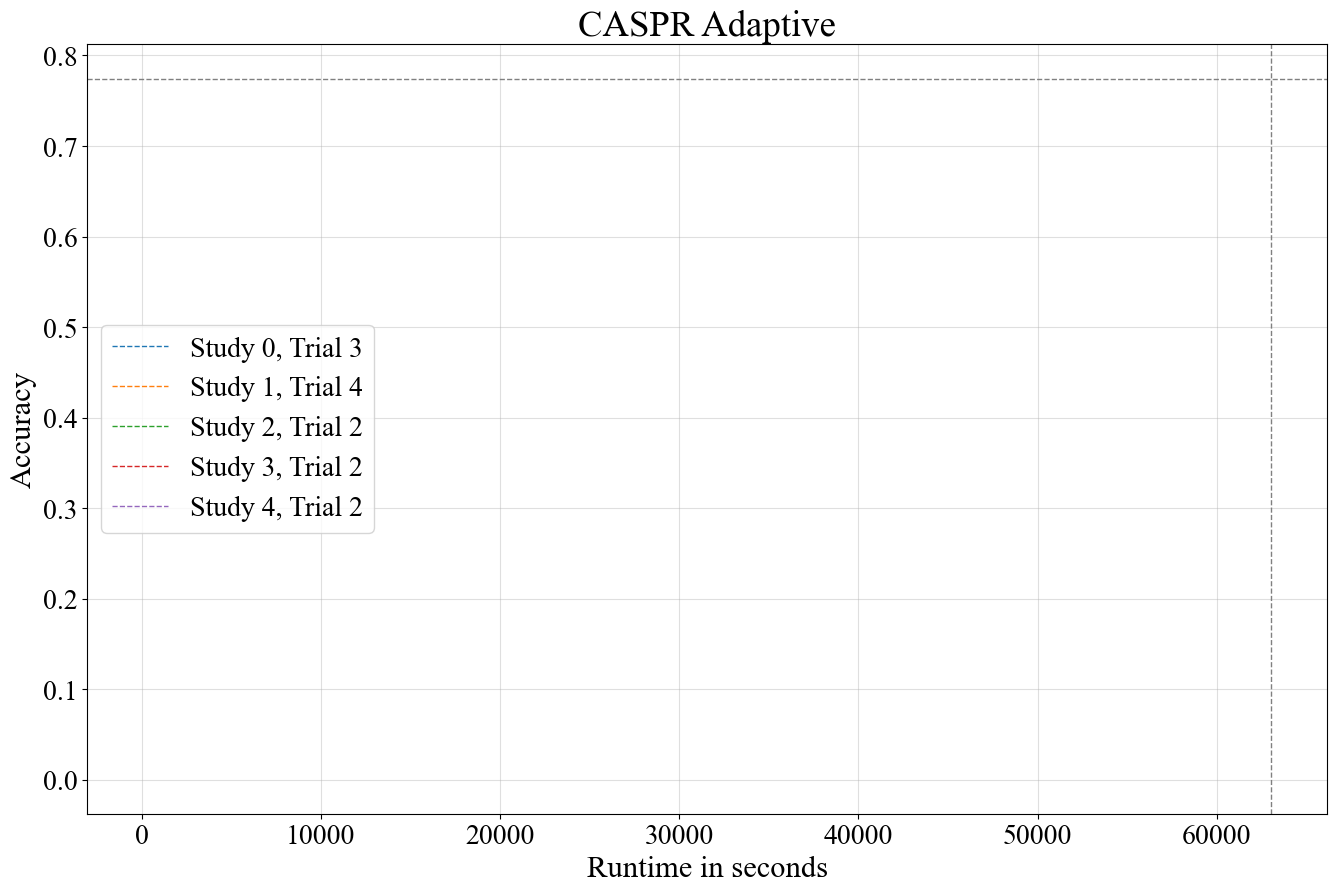

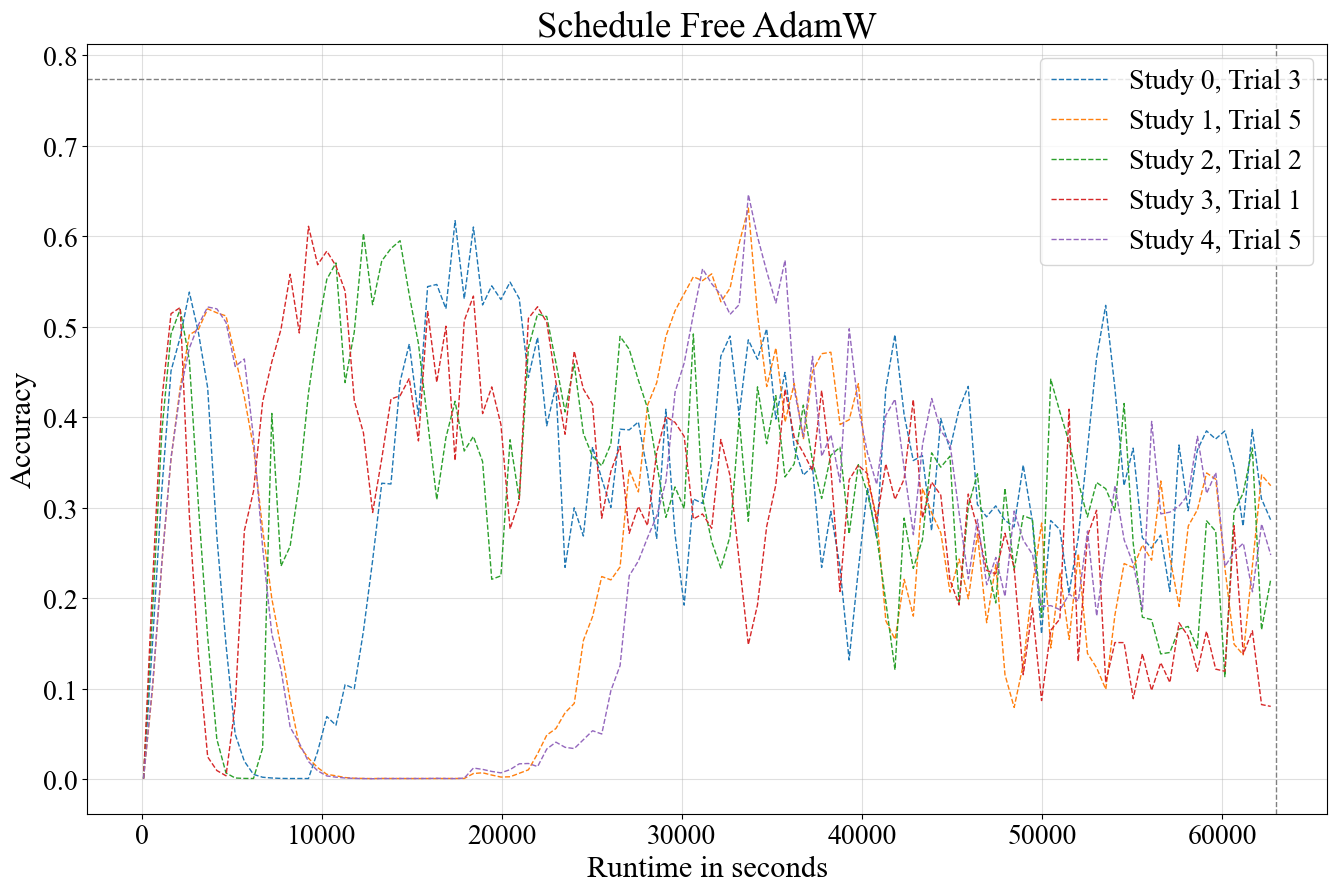

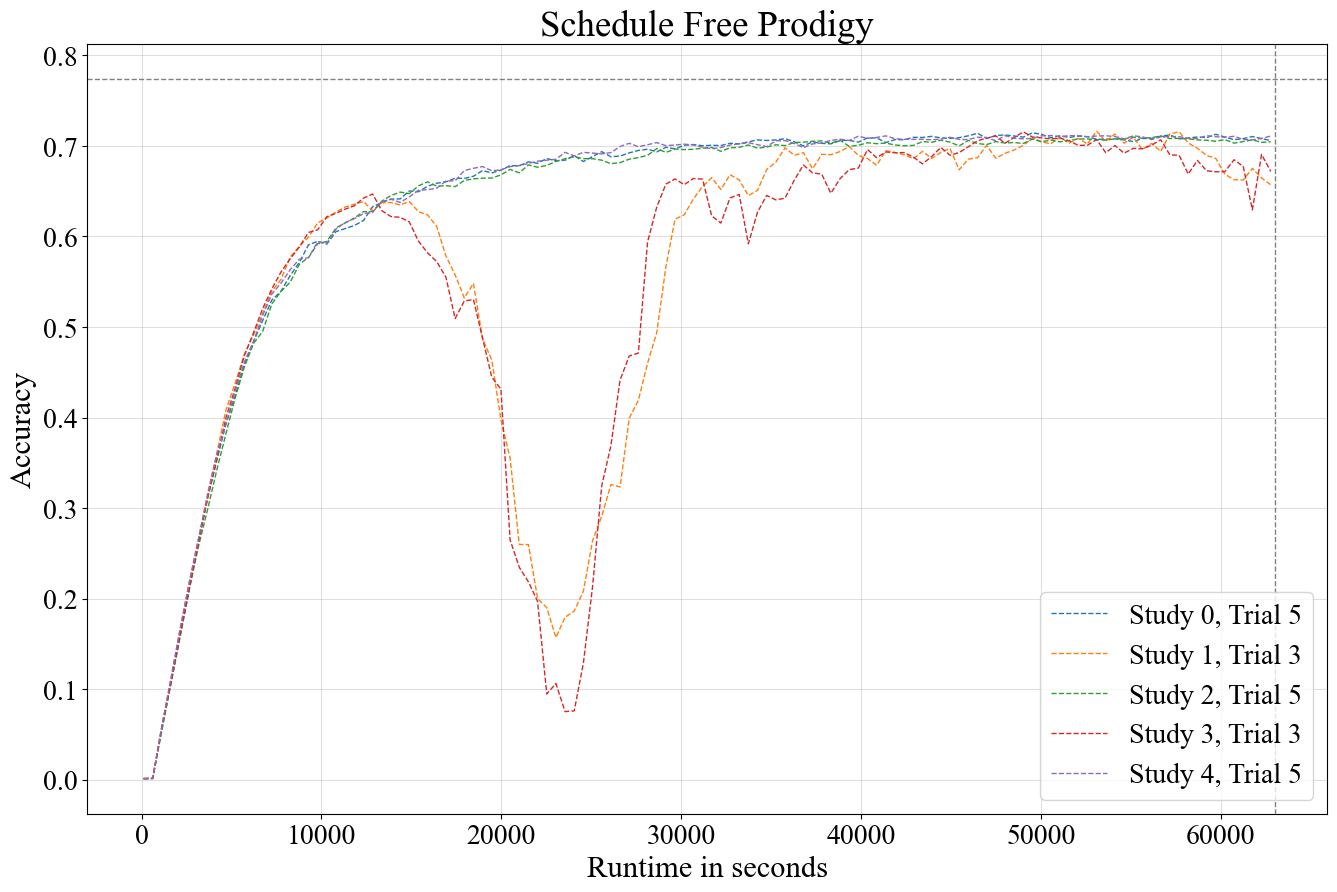

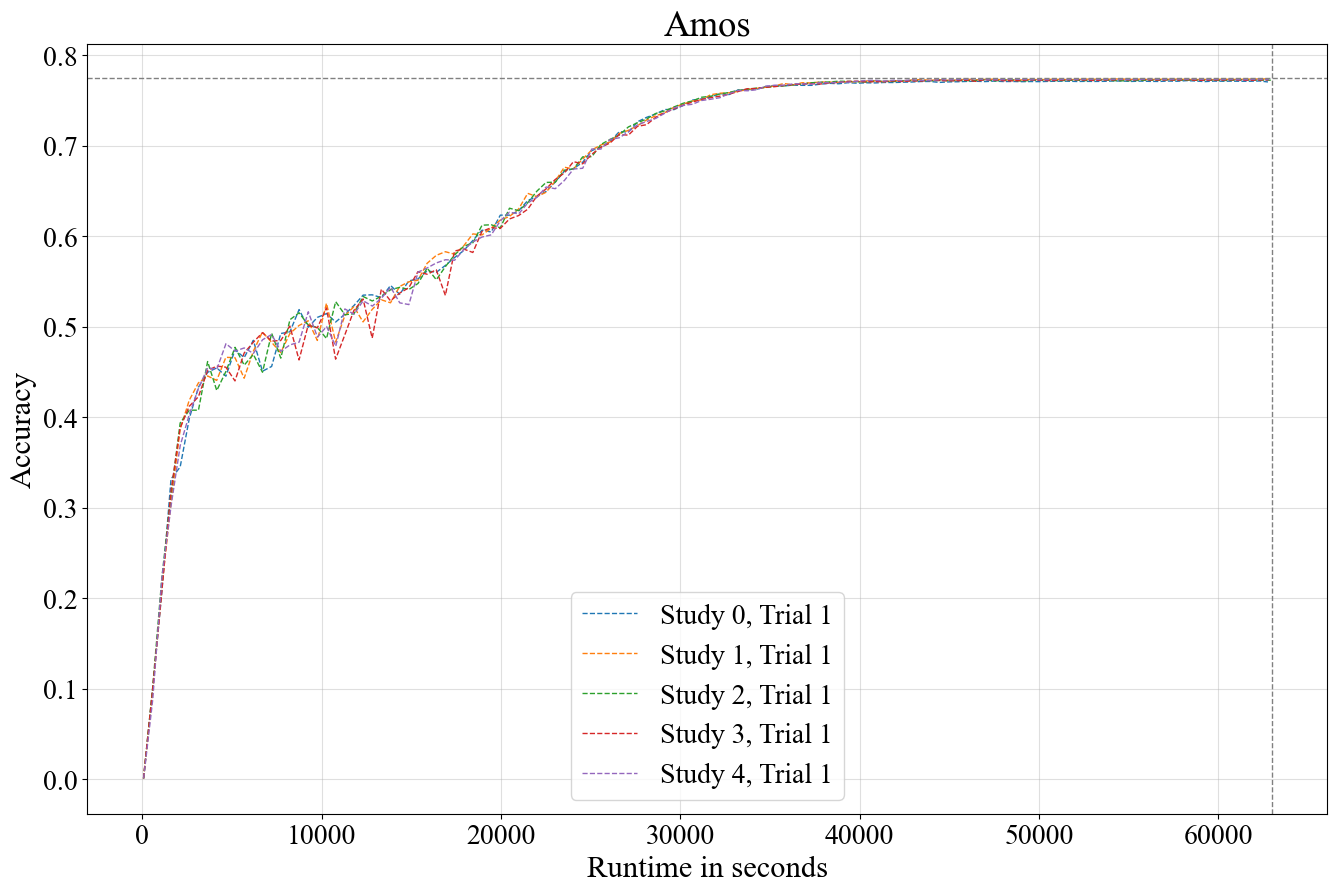

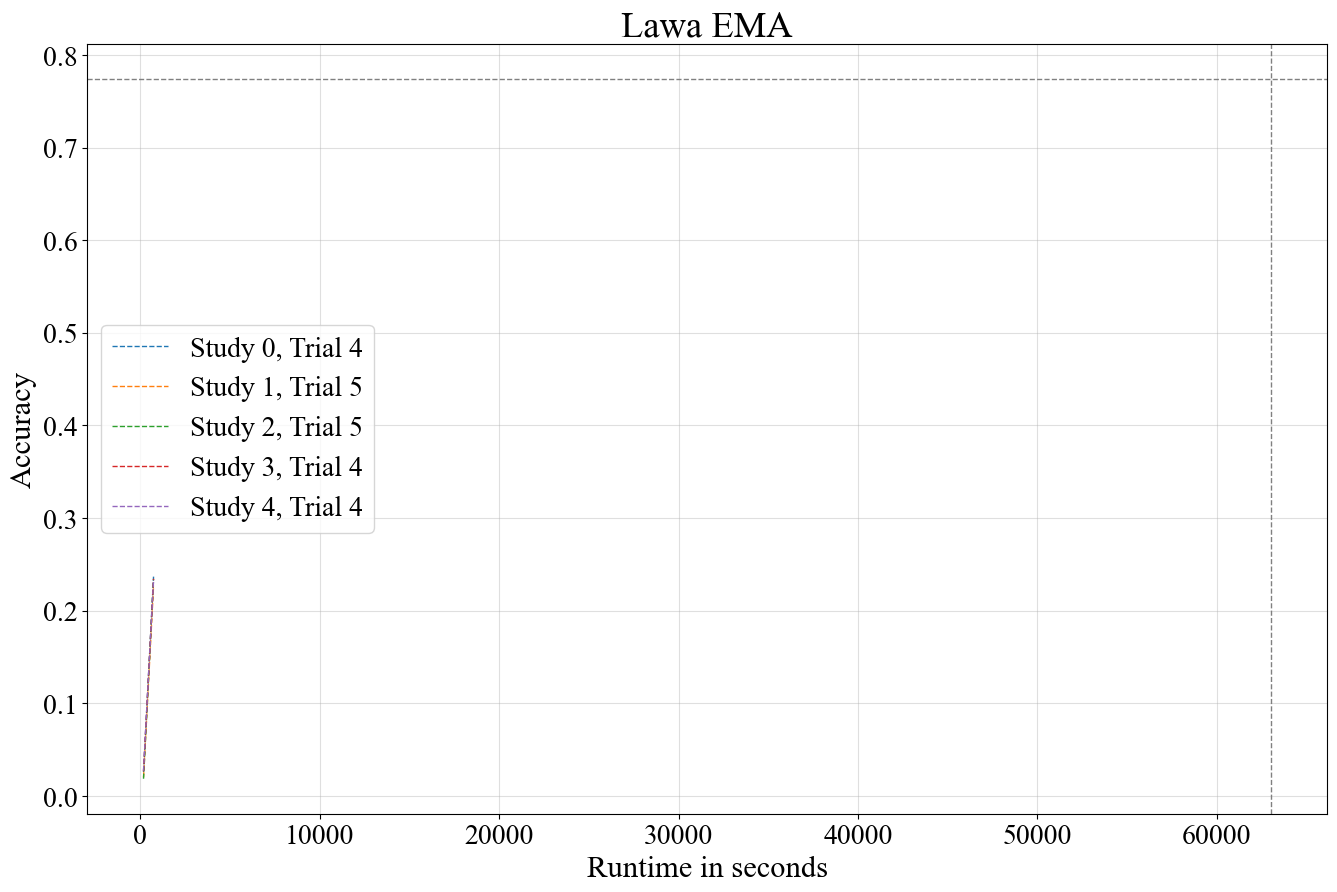

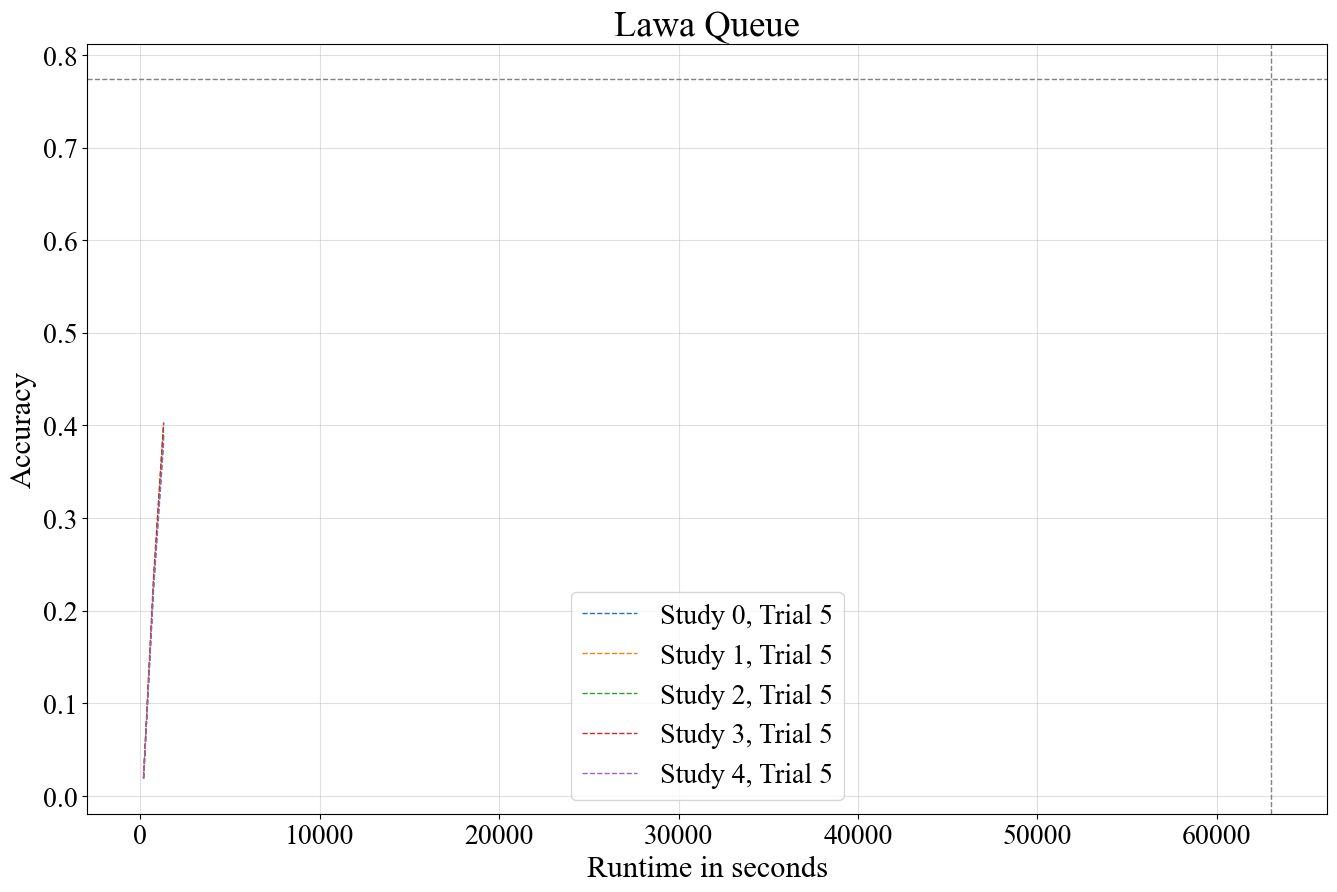

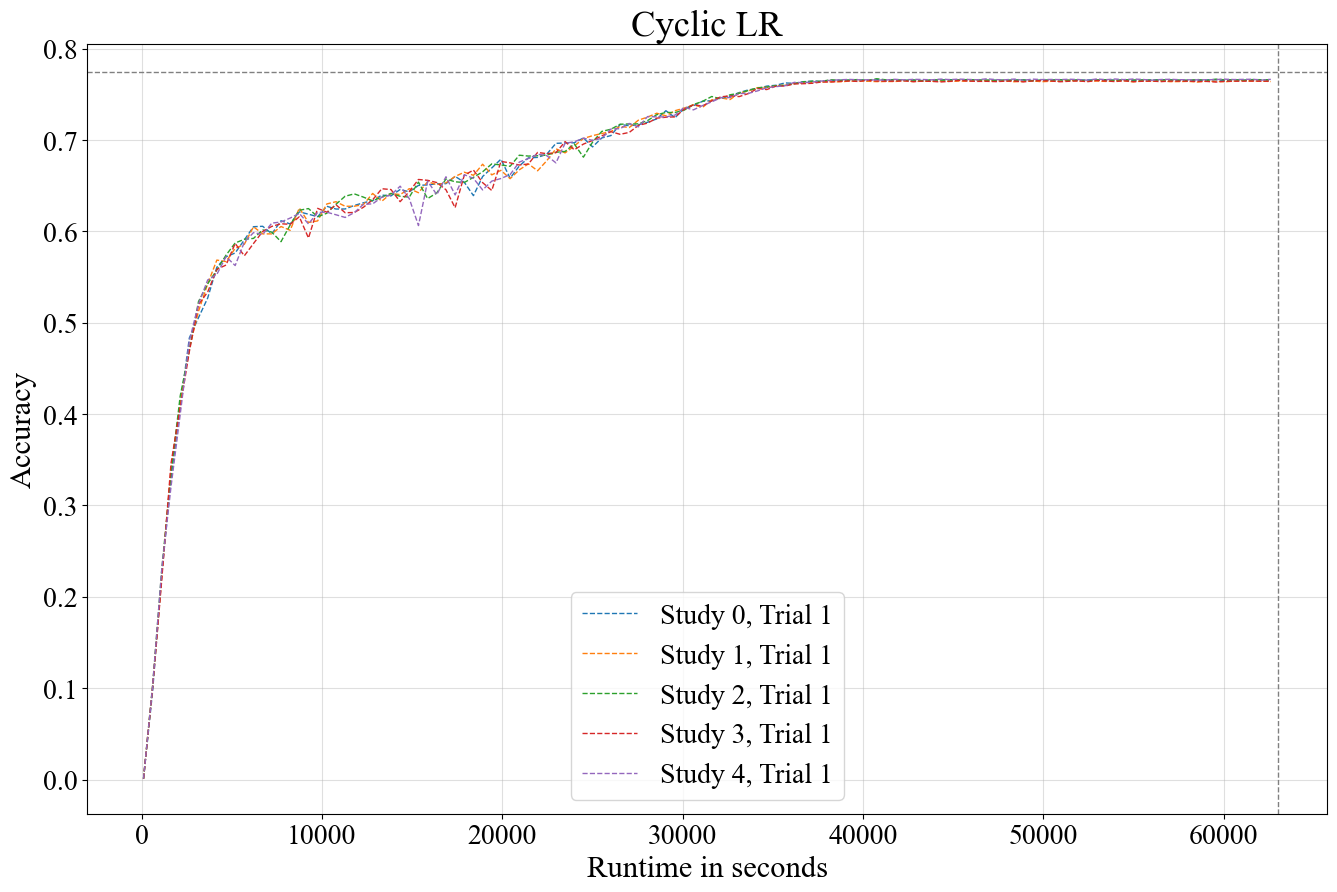

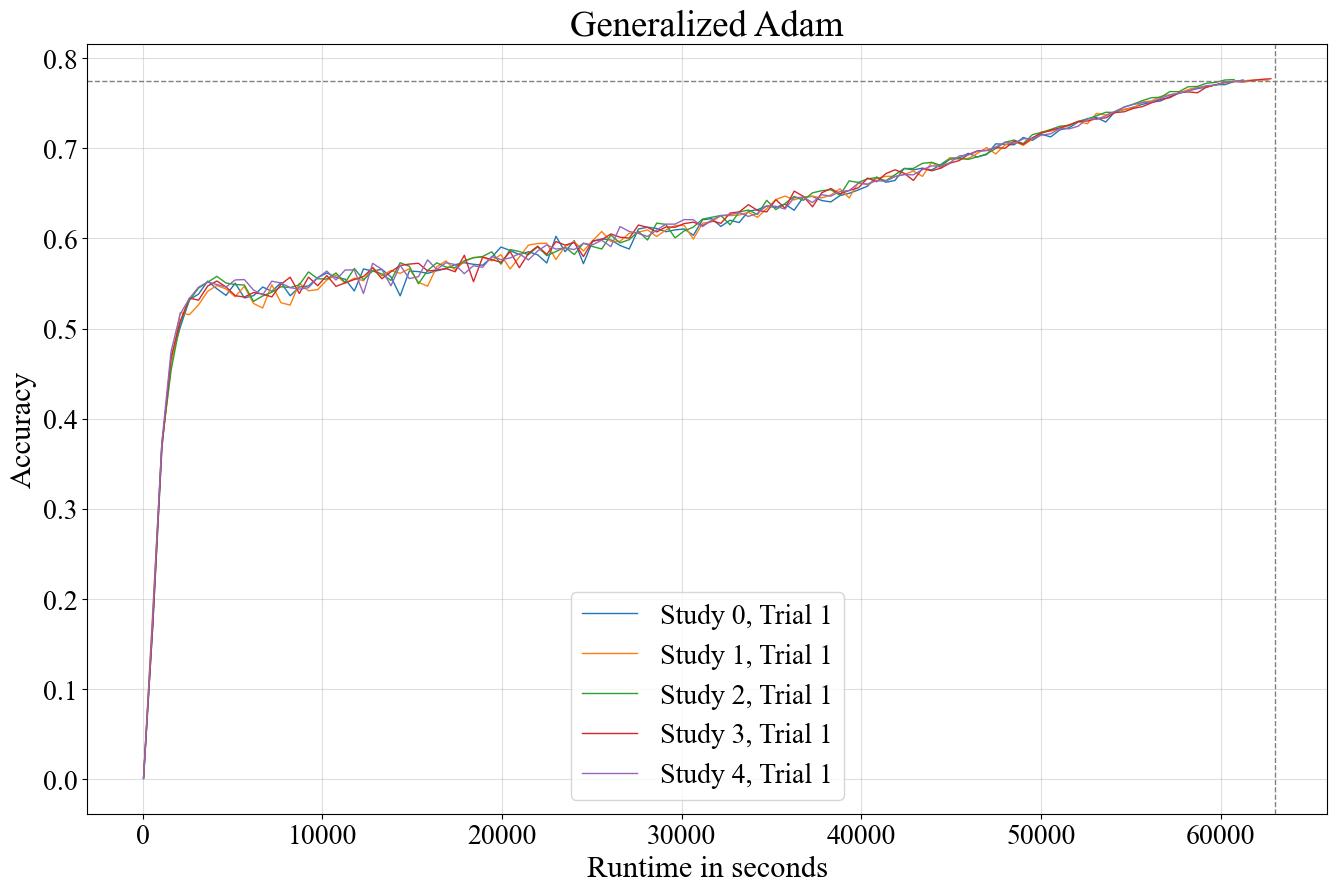

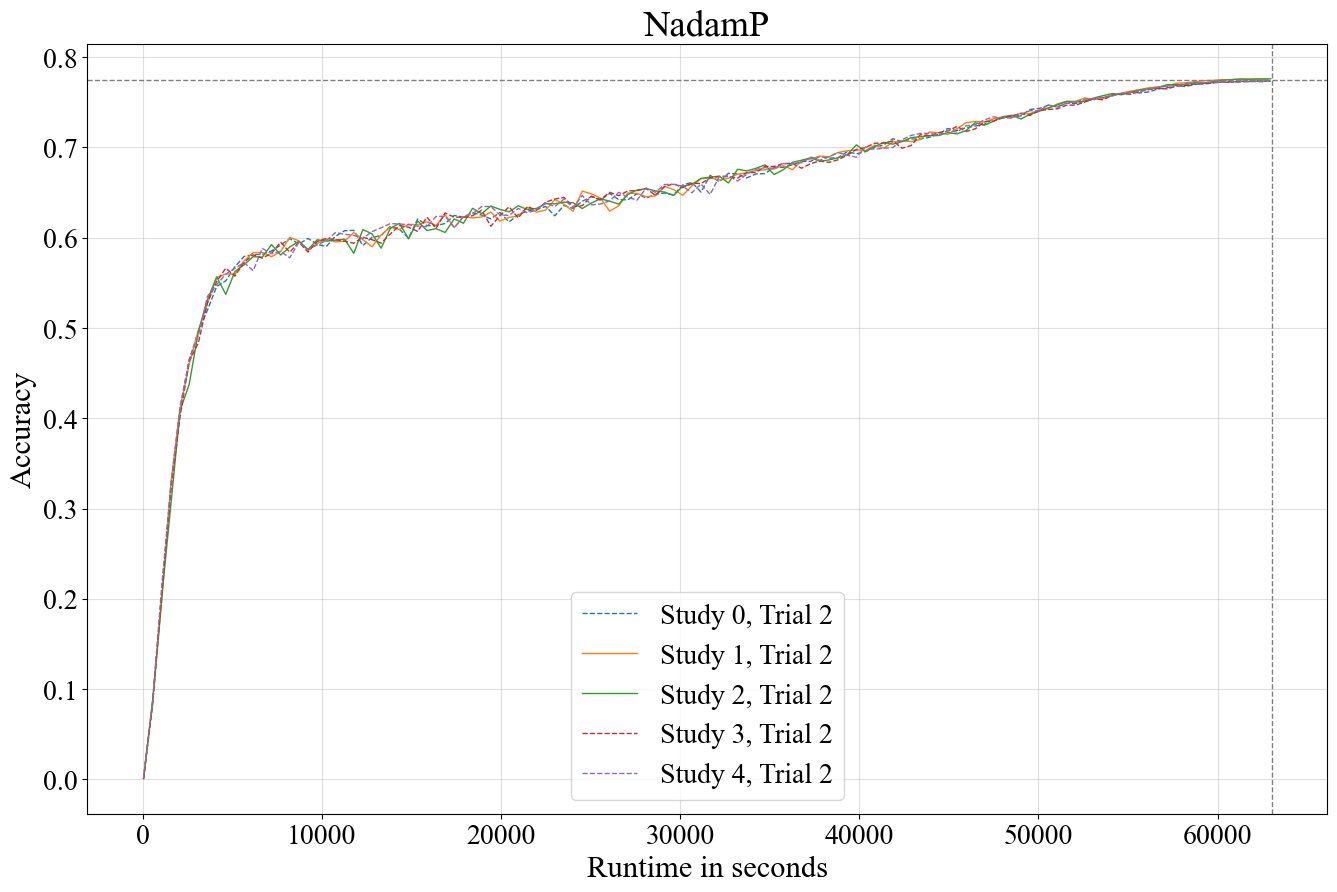

In [21]:
def plot_all_subs(workload, results):
  for sub in results:
    plot_submission(sub, workload, results, title=sub)


plot_all_subs(workload="imagenet_resnet", results=clean_results_df)

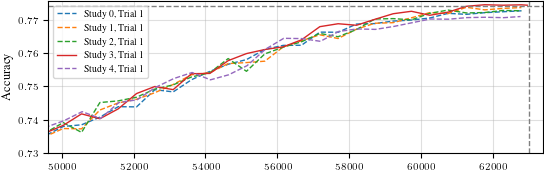

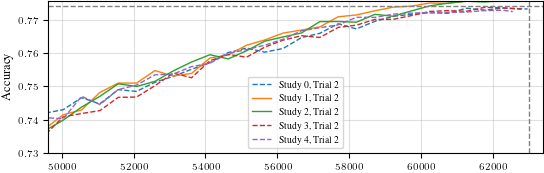

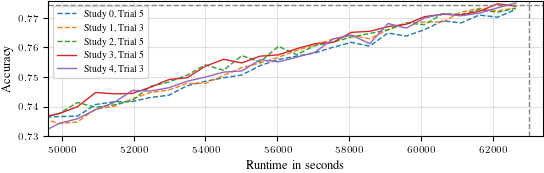

In [6]:
SHOW_SUBMISSIONS = ["prize_qualification_baseline", "nadamp", "shampoo_submission"]

for submission in SHOW_SUBMISSIONS:
    with plt.rc_context(
        {**bundles.iclr2024(), **figsizes.iclr2024(height_to_width_ratio=0.65)}):
        fig, ax = plt.subplots()

        plot_submission(submission, "imagenet_resnet", results_df=clean_results_df, ax=ax)

        if submission != "shampoo_submission":
            ax.set_xlabel("")

        plt.savefig(f"plots/resnet_near_misses_{submission}.pdf")
        plt.show()